In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import json
from sklearn.model_selection import GroupKFold

# Format Data

In [174]:
def permute(image):
    image = torch.Tensor(image)
    image = image.permute(3,0,1,2).numpy()
    return image

In [203]:
DATA_PATH = '../data/brats_dataset/raw_data/'
OUT_PATH = '../data/brats_dataset/processed_data/'

In [206]:
patient_list = [i for i in os.listdir(DATA_PATH) if i.find('g_')!=-1]
n_slices_width = 70

In [207]:
for patient in tqdm(patient_list):
    img_flair = np.array(nib.load(DATA_PATH+patient+'/'+patient+'_flair.nii.gz').dataobj)
    img_t1 = np.array(nib.load(DATA_PATH+patient+'/'+patient+'_t1.nii.gz').dataobj)
    img_t1ce = np.array(nib.load(DATA_PATH+patient+'/'+patient+'_t1ce.nii.gz').dataobj)
    img_t2 = np.array(nib.load(DATA_PATH+patient+'/'+patient+'_t2.nii.gz').dataobj)
    seg = np.array(nib.load(DATA_PATH+patient+'/'+patient+'_seg.nii.gz').dataobj)
    
    img = np.stack([img_flair,img_t1,img_t1ce,img_t2],axis=0)
    
    seg = seg.reshape(1,seg.shape[0],seg.shape[1],seg.shape[2])
    seg[seg==4] = 3

    os.makedirs(OUT_PATH+patient,exist_ok=True)
    
    for i in range(img.shape[-1]//n_slices_width):
        temp = img[:,:,:,i*n_slices_width:(i+1)*n_slices_width]
        temp_y = seg[:,:,:,i*n_slices_width:(i+1)*n_slices_width]
        
        if temp.shape[1]> 256:
            dim = temp.shape[1]
            dim -= 256
            dim /= 2
            dim = int(dim)
            temp = temp[:,dim:-dim,dim:-dim]
            temp_y = temp_y[:,dim:-dim,dim:-dim]
        
        #save
        np.save(OUT_PATH+patient+f'/{i}_voxels.npy',temp)
        np.save(OUT_PATH+patient+f'/{i}_labels.npy',temp_y)
    


100%|██████████| 369/369 [08:16<00:00,  1.34s/it]


In [69]:
seg.shape

(1, 240, 240, 155)

In [159]:
temp = seg[:,:,:,100:101].copy()
temp_y = one_hot_voxel(temp)

temp_y = np.expand_dims(temp_y,axis=0)

In [160]:
temp_y = torch.tensor(temp_y[:,:,:,:,0])

pred = temp_y.permute(0, 2, 3,1)
pred = pred.reshape(-1, pred.shape[-1])

In [163]:
temp_y[0,:,150,150]

tensor([0, 0, 1, 0], dtype=torch.int32)

In [162]:
pred[22500,:]

tensor([1, 0, 0, 0], dtype=torch.int32)

In [121]:
np.where(pred[:,2]==1)

(array([28492, 28493, 28494, ..., 38554, 38555, 38556]),)

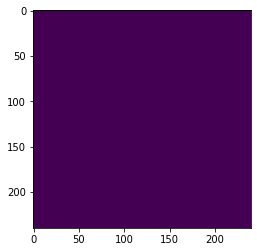

In [202]:
plt.imshow(seg[0,:,:,100])

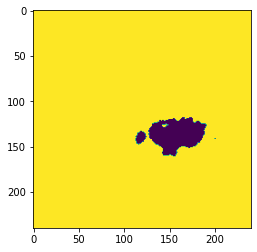

In [94]:
plt.imshow(temp_y[0,:,:,0])

In [166]:
def one_hot_voxel(y):
    y = np.transpose(y.astype(np.int32), (1, 2, 3, 0))
    y = np.eye(4)[y[:, :, :, -1]]
    y = np.transpose(y.astype(np.int32), (3,0,1,2))
    return y

# Prepare split tables

In [178]:
TABLE_PATH = '../data/split_tables/brats/'

In [179]:
patient_list = [OUT_PATH[1:]+i for i in os.listdir(OUT_PATH) if i.find('.')==-1]
print(f'Total number of patients: {len(patient_list)}')

Total number of patients: 23


In [180]:
patient_arr = []
records = []
for patient in patient_list:
    records += [patient+'/'+i for i in os.listdir('.'+patient) if i.find('voxels')!=-1]
    patient_arr += [patient]*len([patient+'/'+i for i in os.listdir('.'+patient) if i.find('voxels')!=-1])
    
records = np.array(records)
patient_arr = np.array(patient_arr)

In [181]:
#create test
kf = GroupKFold(n_splits=2)

for (train,test) in kf.split(records,records,patient_arr):
    
    records_test = records[test]
    
    
    #create test
    split = {
            'test': records_test.tolist(),
        }
    
    with open(f'{TABLE_PATH}test_split_table.json', 'w') as outfile:
            json.dump(split, outfile)
    break

patient_arr = patient_arr[train]
records = records[train]

In [182]:
#create train and validation
kf = GroupKFold(n_splits=2)

for (train,test) in kf.split(records,records,patient_arr):
    
    records_test = records[test]
    
    
    #create test
    split = {
            'test': records_test.tolist(),
        }
    
    with open(f'{TABLE_PATH}test_split_table.json', 'w') as outfile:
            json.dump(split, outfile)
    break

patient_arr = patient_arr[train]
records = records[train]

In [183]:
#create train and validation
n_patients = [1,2,4,8]

patients_unique = np.unique(patient_arr)

for i in n_patients:
    
    train_patients = patients_unique[:i]
    train_records = np.empty(0)
    for patient in train_patients.tolist():
        train_records = np.append(train_records,records[patient_arr==patient],axis=0)
    
    val_patients = patients_unique[-2:]
    val_records = np.empty(0)
    for patient in val_patients.tolist():
        val_records = np.append(val_records,records[patient_arr==patient],axis=0)
    
    
    
    split = {
            'train': train_records.tolist(),
            'val': val_records.tolist(),
            'pretrain': records.tolist(),
        }
    with open(f'{TABLE_PATH}{i}_split_table.json', 'w') as outfile:
            json.dump(split, outfile)


In [184]:
#create UB

train_patients = patients_unique[:patients_unique.shape[0]//2]
train_records = np.empty(0)
for patient in train_patients.tolist():
    train_records = np.append(train_records,records[patient_arr==patient],axis=0)

val_patients = patients_unique[patients_unique.shape[0]//2:]
val_records = np.empty(0)
for patient in val_patients.tolist():
    val_records = np.append(val_records,records[patient_arr==patient],axis=0)

split = {
        'train': train_records.tolist(),
        'val': val_records.tolist(),
        }
with open(f'{TABLE_PATH}UB_split_table.json', 'w') as outfile:
            json.dump(split, outfile)
